# Projet Annuel : Prédiction de différents type de terrains sportifs (Football, Basket, Rugby)

## Sujet choisi : La prédiction de différents types de terrain sportifs

## Première étape : Constitution du dataset

### Récupération des données via web-scraping

En ce qui concerne la constitution du dataset, la majorité des images de chaque classe ont été récupérées via un script de web-scraping écrit en python permettant de récupérer les images de chaque classe et de les télécharger.

### Filtre des images

Etant donné que ces images sont récupérées via web scraping, il y a eu des moments où certaines images ne correspondaient pas à ce qui était recherché (Problème de format, image non conforme etc). Cela a été l'étape la plus fastidieuse car cela devait être fait manuellement.

# Seconde étape : Implémentation des différents modèles demandés :

## Import des modules nécessaires

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ctypes
import sys
import os

### Définition de la variable d'environnement RUST_BACKTRACE permettant de récupérer la stacktrace de la librairie en cas d'erreur et faciliter le débogage

In [2]:
os.putenv("RUST_BACKTRACE", "full")

### Définition d'un dictionnaire permettant de récupérer l'éxecutable de la librairie peu importe l'os

In [3]:
computer_plateform = sys.platform
library_mapping = {
    "linux": r"./library/target/debug/liblibrary.so",
    "windows": r"./library/target/debug/liblibrary.dll",
    "darwin": r"./library/target/debug/liblibrary.dylib",
}

lib = ctypes.CDLL(library_mapping.get(computer_plateform))

## Modèle linéaire
Tout d'abord, on a décidé d'implémenter le modèle linéaire, afin de tester la validité du code écrit par notre groupe, on s'est servi des cas de test fourni par notre professeur.
Vous trouverez ci-dessous les cas de tests pour le modèle linéaire appliqué à la librairie qu'on a conçu.

### Définition de la structure LinearCLassifier

In [4]:
class LinearClassifier(ctypes.Structure):
    _fields_ = [
        ('weights', ctypes.POINTER(ctypes.c_float)),
        ('size', ctypes.c_size_t),
    ]

### Définition des types des paramètres de chaque fonction ainsi que le type de retour lorsque cela est nécessaire

In [5]:
new_ml_arg_dict = {
    "num_features": ctypes.c_size_t
}
lib.new.argtypes = list(new_ml_arg_dict.values())
lib.new.restype = ctypes.POINTER(LinearClassifier)

train_regression_arg_dict = {
    'lm': ctypes.POINTER(LinearClassifier),
    'flattened_dataset_inputs': ctypes.POINTER(ctypes.c_float),
    'flattened_dataset_expected_outputs': ctypes.POINTER(ctypes.c_float),
    'len_input': ctypes.c_size_t,
    'len_output': ctypes.c_size_t,
}
lib.train_regression.argtypes = list(train_regression_arg_dict.values())
lib.train_regression.restype = None

train_classification_arg_dict = {
    'lm': ctypes.POINTER(LinearClassifier),
    'flattened_dataset_inputs': ctypes.POINTER(ctypes.c_float),
    'flattened_dataset_expected_outputs': ctypes.POINTER(ctypes.c_float),
    'len_input': ctypes.c_size_t,
    'len_output': ctypes.c_size_t,
    'lr': ctypes.c_float,
    'epochs': ctypes.c_int
}
lib.train_classification.argtypes = list(train_classification_arg_dict.values())
lib.train_classification.restype = None

predict_classification_arg_dict = {
    'lm': ctypes.POINTER(LinearClassifier),
    'inputs': ctypes.POINTER(ctypes.c_float),
    'inputs_size': ctypes.c_size_t,
}
lib.predict_classification.argtypes = list(predict_classification_arg_dict.values())
lib.predict_classification.restype = ctypes.c_float

predict_regression_arg_dict = {
    'lm': ctypes.POINTER(LinearClassifier),
    'inputs': ctypes.POINTER(ctypes.c_float),
    'inputs_size': ctypes.c_size_t,
}
lib.predict_regression.argtypes = list(predict_regression_arg_dict.values())
lib.predict_regression.restype = ctypes.c_float

lib.delete_model.argtypes = [ctypes.POINTER(LinearClassifier)]
lib.delete_model.restype = None

#### Cas simple (KO)

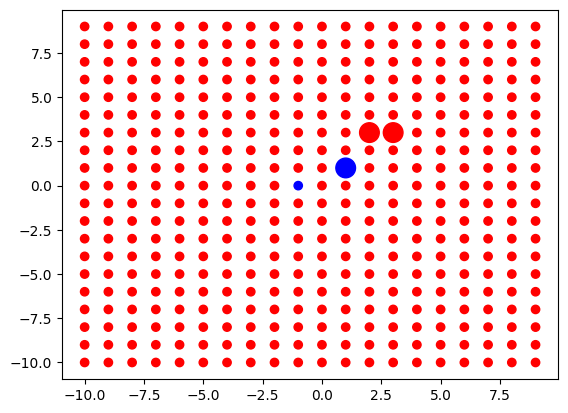

In [6]:
linear_classifier_object = lib.new(2)

X = np.array([
    [1, 1],
    [2, 3],
    [3, 3]
])
Y = np.array([
    1,
    -1,
    -1
])

flattened_inputs = X.flatten().astype(np.float32)
arr_inputs = flattened_inputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

flattened_outputs = Y.flatten().astype(np.float32)
arr_outputs = flattened_outputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

test_dataset_inputs = [[x1, x2] for x1 in range(-10, 10) for x2 in range(-10, 10)]
colors = ["blue" if output >= 0 else "red" for output in Y]

lib.train_classification(linear_classifier_object, arr_inputs, arr_outputs, len(flattened_inputs),
                         len(flattened_outputs), 0.1, 10000)

predicted_outputs = []
for p in test_dataset_inputs:
    arr_res1 = (ctypes.c_float * len(p))(*p)
    curr = lib.predict_classification(linear_classifier_object, arr_res1, len(p))
    predicted_outputs.append(curr)

predicted_outputs_colors = ['blue' if label == 0 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset_inputs], [p[1] for p in test_dataset_inputs], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.show()
lib.delete_model(linear_classifier_object)

#### Cas Multiple (KO)

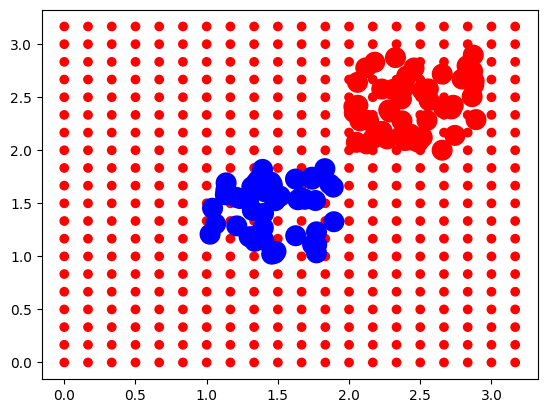

In [7]:
linear_classifier_object = lib.new(2)

X = np.concatenate(
    [np.random.random((50, 2)) * 0.9 + np.array([1, 1]), np.random.random((50, 2)) * 0.9 + np.array([2, 2])])
Y = np.concatenate([np.ones((50, 1)), np.ones((50, 1)) * -1.0, np.ones((50, 1)) * -1.0])

flattened_inputs = X.flatten().astype(np.float32)
arr_inputs = flattened_inputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

flattened_outputs = Y.flatten().astype(np.float32)
arr_outputs = flattened_outputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

test_dataset_inputs = [[float(x1) / 6, float(x2) / 6] for x1 in range(0, 20) for x2 in
                       range(0, 20)]
colors = ["blue" if output >= 0 else "red" for output in Y]

lib.train_classification(linear_classifier_object, arr_inputs, arr_outputs, len(flattened_inputs),
                         len(flattened_outputs), 0.1, 1000)

predicted_outputs = []
for p in test_dataset_inputs:
    arr_res1 = ctypes.c_float * len(p)
    arr_res2 = arr_res1(*p)
    curr = lib.predict_classification(linear_classifier_object, arr_res2, len(p))
    predicted_outputs.append(curr)

predicted_outputs_colors = ['blue' if label == 1 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset_inputs], [p[1] for p in test_dataset_inputs], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors[0:100], s=200)
plt.show()
lib.delete_model(linear_classifier_object)

#### XOR (KO)

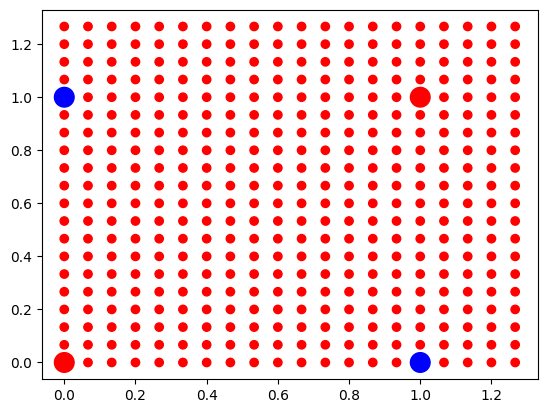

In [8]:
linear_classifier_object = lib.new(2)

X = np.array([[1, 0], [0, 1], [0, 0], [1, 1]])
Y = np.array([1, 1, -1, -1])

flattened_inputs = X.flatten().astype(np.float32)
arr_inputs = flattened_inputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

flattened_outputs = Y.flatten().astype(np.float32)
arr_outputs = flattened_outputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

test_dataset_inputs = [[x1 / 15, x2 / 15] for x1 in range(0, 20) for x2 in range(0, 20)]
colors = ["blue" if output >= 0 else "red" for output in Y]

lib.train_classification(linear_classifier_object, arr_inputs, arr_outputs, len(flattened_inputs),
                         len(flattened_outputs), 0.1, 1000)

predicted_outputs = []
for p in test_dataset_inputs:
    arr_res1 = ctypes.c_float * len(p)
    arr_res2 = arr_res1(*p)
    curr = lib.predict_classification(linear_classifier_object, arr_res2, len(p))
    predicted_outputs.append(curr)

predicted_outputs_colors = ['blue' if label == 1 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset_inputs], [p[1] for p in test_dataset_inputs], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.show()
lib.delete_model(linear_classifier_object)

## Régression

In [ ]:
# Noyau plante
X = np.array([
    [1],
    [2]
])
Y = np.array([
    2,
    3
])

linear_regression_object = lib.new(1)
flattened_inputs = X.flatten().astype(np.float32)
arr_inputs = flattened_inputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

flattened_outputs = Y.flatten().astype(np.float32)
arr_outputs = flattened_outputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

lib.train_regression(linear_regression_object, arr_inputs, arr_outputs, len(flattened_inputs), len(flattened_outputs))

test_inputs = np.array(test_dataset_inputs, dtype=np.float32, order='C')
flattened_test_inputs = test_inputs.flatten()
arr_test_inputs = flattened_test_inputs.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

predicted_outputs = []
for p in test_dataset_inputs:
    arr_res2 = (ctypes.c_float * 1)(*p)
    print(arr_res2)
    d = lib.predict_regression(linear_regression_object, arr_res2, 1)
    predicted_outputs.append(d)

plt.plot([p[0] for p in test_dataset_inputs], predicted_outputs)
plt.scatter([p[0] for p in test_dataset_inputs], predicted_outputs, s=200)
plt.axis([-10, 10, -10, 10])
plt.show()
lib.delete_model(linear_regression_object)

# Perceptron multi couche

Ensuite on a implémenté le perceptron multi couche, afin de tester la validité du code écrit par notre groupe, on s'est servi des cas de test fourni par notre professeur.
Vous trouverez ci-dessous les cas de tests pour le modèle linéaire appliqué à la librairie qu'on a conçu.

### Définition des structure utilisés dans la librairie afin d'appeler les fonction avec les bons types

In [5]:
class Veci64(ctypes.Structure):
    _fields_ = [("data", ctypes.POINTER(ctypes.c_int64)),
                ("length", ctypes.c_size_t),
                ("capacity", ctypes.c_size_t)]


class Vecf32(ctypes.Structure):
    _fields_ = [("data", ctypes.POINTER(ctypes.c_float)),
                ("length", ctypes.c_size_t),
                ("capacity", ctypes.c_size_t)]


class Vec2df32(ctypes.Structure):
    _fields_ = [("data", ctypes.POINTER(Vecf32)),
                ("length", ctypes.c_size_t),
                ("capacity", ctypes.c_size_t)]


class Vec3df32(ctypes.Structure):
    _fields_ = [("data", ctypes.POINTER(Vec2df32)),
                ("length", ctypes.c_size_t),
                ("capacity", ctypes.c_size_t)]


class PMC(ctypes.Structure):
    _fields_ = [
        ('layers', ctypes.c_uint),
        ('dimensions', ctypes.POINTER(Veci64)),
        ('X', ctypes.POINTER(Vec2df32)),
        ('W', ctypes.POINTER(Vec2df32)),
        ('deltas', ctypes.POINTER(Vec2df32)),
    ]

### Définition des types des paramètres de chaque fonction ainsi que le type de retour lorsque cela est nécessaire

In [6]:
new_pmc_model_arg_dict = {
    "dimensions_arr": ctypes.POINTER(ctypes.c_int64),
    "layer_size_per_neuron": ctypes.c_size_t,
}
lib.new_pmc.argtypes = list(new_pmc_model_arg_dict.values())
lib.new_pmc.restype = ctypes.POINTER(PMC)

train_pmc_model_arg_dict = {
    "model": ctypes.POINTER(PMC),
    "dataset_inputs": ctypes.POINTER(ctypes.c_float),
    "dataset_inputs_size": ctypes.c_size_t,
    "flattened_dataset_outputs": ctypes.POINTER(ctypes.c_float),
    "alpha": ctypes.c_float,
    "epochs": ctypes.c_int32,
    "is_classification": ctypes.c_bool
}
lib.train_pmc_model.argtypes = list(train_pmc_model_arg_dict.values())
lib.train_pmc_model.restype = None

predict_pmc_model_arg_dict = {
    "model": ctypes.POINTER(PMC),
    "sample_inputs": ctypes.POINTER(ctypes.c_float),
    "sample_inputs_size": ctypes.c_size_t,
    "is_classification": ctypes.c_bool
}
lib.predict_pmc_model.argtypes = list(predict_pmc_model_arg_dict.values())
lib.predict_pmc_model.restype = ctypes.POINTER(ctypes.c_float)

lib.delete_pmc_model.argtypes = [ctypes.POINTER(PMC)]
lib.delete_pmc_model.restype = None

get_X_len_arg_dict = {
    "model": ctypes.POINTER(PMC)
}
lib.get_X_len.argtypes = list(get_X_len_arg_dict.values())
lib.get_X_len.restype = ctypes.c_int

#### Cas Simple (KO)

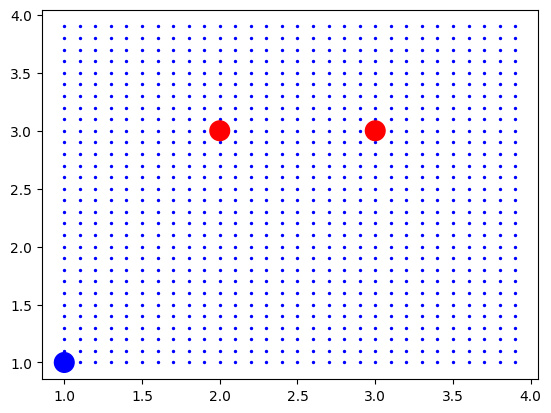

In [6]:
X = np.array([[1, 1], [2, 3], [3, 3]])
Y = np.array([1, -1, -1])

flattened_inputs = X.flatten().astype(np.float32)
arr_inputs = (ctypes.c_float * len(flattened_inputs))(*flattened_inputs)

flattened_outputs = Y.flatten().astype(np.float32)
arr_outputs = (ctypes.c_float * len(flattened_outputs))(*flattened_outputs)

colors = ["blue" if output >= 0 else "red" for output in Y]

dimensions = [2, 1]
dimensions_arr = (ctypes.c_int64 * len(dimensions))(*dimensions)

pmc_model = lib.new_pmc(dimensions_arr, len(dimensions_arr))

lib.train_pmc_model(
    pmc_model,
    arr_inputs,
    len(flattened_inputs),
    arr_outputs,
    ctypes.c_float(0.001),
    ctypes.c_int32(100),
    ctypes.c_bool(True),
)

test_dataset = [[x1 / 10, x2 / 10] for x1 in range(10, 40) for x2 in range(10, 40)]
sample_inputs = np.array(test_dataset, dtype=np.float32)
flattened_inputs = sample_inputs.flatten()
arr_inputs = (ctypes.c_float * len(flattened_inputs))(*flattened_inputs)

predicted_outputs_ptr = lib.predict_pmc_model(
    pmc_model,
    arr_inputs,
    len(flattened_inputs),
    ctypes.c_bool(True),
)
predicted_outputs = np.ctypeslib.as_array(
    predicted_outputs_ptr,
    shape=(lib.get_X_len(pmc_model),),
)

predicted_outputs_colors = ["blue" if label >= 0 else "red" for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors, s=2)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.show()

lib.delete_pmc_model(pmc_model)

#### Cas Multiple (KO)

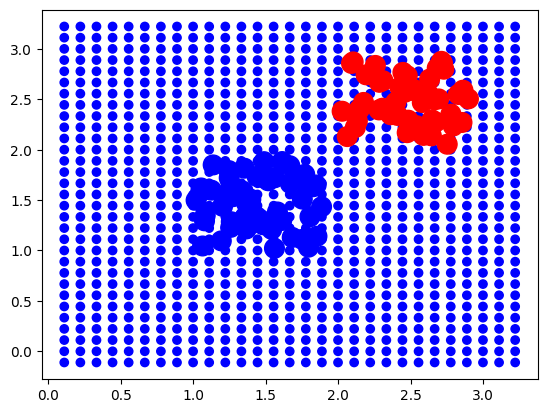

In [7]:
X = np.concatenate(
    [np.random.random((50, 2)) * 0.9 + np.array([1, 1]), np.random.random((50, 2)) * 0.9 + np.array([2, 2])])
Y = np.concatenate([np.ones((50, 1)), np.ones((50, 1)) * -1.0])

flattened_inputs = X.flatten().astype(np.float32)
arr_inputs = (ctypes.c_float * len(flattened_inputs))(*flattened_inputs)

flattened_outputs = Y.flatten().astype(np.float32)
arr_outputs = (ctypes.c_float * len(flattened_outputs))(*flattened_outputs)

colors = ["blue" if output >= 0 else "red" for output in Y]

dimensions = [2, 1]
dimensions_arr = (ctypes.c_int64 * len(dimensions))(*dimensions)

pmc_model = lib.new_pmc(dimensions_arr, len(dimensions_arr))

lib.train_pmc_model(pmc_model, arr_inputs, len(flattened_inputs), arr_outputs, ctypes.c_float(0.001),
                    ctypes.c_int32(100000), ctypes.c_bool(True))

test_dataset = [[x1 / 9, x2 / 9] for x1 in range(1, 30) for x2 in range(-1, 30)]
sample_inputs = np.array(test_dataset, dtype=np.float32)
flattened_inputs = sample_inputs.flatten()

arr_inputs = (ctypes.c_float * len(flattened_inputs))(*flattened_inputs)

predicted_outputs = []
for p in range(len(test_dataset)):
    prediction = lib.predict_pmc_model(pmc_model, arr_inputs, len(flattened_inputs), ctypes.c_bool(True))
    arr = np.ctypeslib.as_array(prediction, (lib.get_X_len(pmc_model),))
    predicted_outputs.append(arr[0])

predicted_outputs_colors = ['blue' if label >= 0 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.show()
lib.delete_pmc_model(pmc_model)

#### XOR (KO)

In [ ]:
X = np.array([[1, 0], [0, 1], [0, 0], [1, 1]])
Y = np.array([1, 1, -1, -1])

flattened_inputs = X.flatten().astype(np.float32)
arr_inputs = (ctypes.c_float * len(flattened_inputs))(*flattened_inputs)

flattened_outputs = Y.flatten().astype(np.float32)
arr_outputs = (ctypes.c_float * len(flattened_outputs))(*flattened_outputs)

colors = ["blue" if output >= 0 else "red" for output in Y]

dimensions = [2, 2, 1]
dimensions_arr = (ctypes.c_int64 * len(dimensions))(*dimensions)

pmc_model = lib.new_pmc(dimensions_arr, len(dimensions_arr))

lib.train_pmc_model(pmc_model, arr_inputs, len(flattened_inputs), arr_outputs, ctypes.c_float(0.001),
                    ctypes.c_int32(100000), ctypes.c_bool(True))

test_dataset = [[x1 / 10, x2 / 10] for x1 in range(-10, 20) for x2 in range(-10, 20)]
sample_inputs = np.array(test_dataset, dtype=np.float32)
flattened_inputs = sample_inputs.flatten()

arr_inputs = (ctypes.c_float * len(flattened_inputs))(*flattened_inputs)

predicted_outputs = []
for p in range(len(test_dataset)):
    prediction = lib.predict_pmc_model(pmc_model, arr_inputs, len(flattened_inputs), ctypes.c_bool(True))
    arr = np.ctypeslib.as_array(prediction, (lib.get_X_len(pmc_model),))
    predicted_outputs.append(arr[0])

predicted_outputs_colors = ['blue' if label >= 0 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.show()
lib.delete_pmc_model(pmc_model)

#### Multi Linear 3 classes

In [ ]:
X = np.random.random((500, 2)) * 2.0 - 1.0
Y = np.array([[1, 0, 0] if -p[0] - p[1] - 0.5 > 0 and p[1] < 0 and p[0] - p[1] - 0.5 < 0 else
              [0, 1, 0] if -p[0] - p[1] - 0.5 < 0 and p[1] > 0 and p[0] - p[1] - 0.5 < 0 else
              [0, 0, 1] if -p[0] - p[1] - 0.5 < 0 and p[1] < 0 and p[0] - p[1] - 0.5 > 0 else
              [0, 0, 0] for p in X])

X = X[[not np.all(arr == [0, 0, 0]) for arr in Y]]
Y = Y[[not np.all(arr == [0, 0, 0]) for arr in Y]]

flattened_inputs = X.flatten().astype(np.float32)
arr_inputs = (ctypes.c_float * len(flattened_inputs))(*flattened_inputs)

flattened_outputs = Y.flatten().astype(np.float32)
arr_outputs = (ctypes.c_float * len(flattened_outputs))(*flattened_outputs)

colors = ["blue" if np.argmax(output) == 0 else ("red" if np.argmax(output) == 1 else "green") for output in
          Y]

dimensions = [2, 3]
dimensions_arr = (ctypes.c_int64 * len(dimensions))(*dimensions)

pmc_model = lib.new_pmc(dimensions_arr, len(dimensions_arr))

lib.train_pmc_model(pmc_model, arr_inputs, len(flattened_inputs), arr_outputs, ctypes.c_float(0.001),
                    ctypes.c_int32(100000), ctypes.c_bool(True))

test_dataset = [[x1 / 10, x2 / 10] for x1 in range(-10, 10) for x2 in range(-10, 10)]
sample_inputs = np.array(test_dataset, dtype=np.float32)
flattened_inputs = sample_inputs.flatten()

arr_inputs = (ctypes.c_float * len(flattened_inputs))(*flattened_inputs)

predicted_outputs = []
for p in range(len(test_dataset)):
    prediction = lib.predict_pmc_model(pmc_model, arr_inputs, len(flattened_inputs), ctypes.c_bool(True))
    arr = np.ctypeslib.as_array(prediction, (lib.get_X_len(pmc_model),))
    predicted_outputs.append(arr[0])
predicted_outputs_colors = ["blue" if np.argmax(output) == 0 else ("red" if np.argmax(output) == 1 else "green") for
                            output in predicted_outputs]

# predicted_outputs_colors = ['blue' if label >= 0 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=200)
plt.show()
lib.delete_pmc_model(pmc_model)

## Mise en place de l'application

Afin de pouvoir montrer ce qui a été produit lors de ce projet, il nous a été demandé de mettre en place une application afin de démontrer la confirmité de l'implémentation des modèles demandés avec la possibilité de charger des nouvelles données au sein de nos modèles ou bien de sauvegarder ces dernier pour une utilisation future.

Vous trouverez ci-dessous quelques images de l'application conçue ainsi que la démonstration de certaines fonctionnalités